In [1]:
# Libraries
from dotenv import load_dotenv
import os
# from tom_localizer import ImportLLMfromHF, ToMLocalizerUnits, ToMLocDataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from prompt_processing import process_text_file

In [2]:
# Initialization of the environment
# Load the variable from .env
load_dotenv()
hf_access_token = os.getenv("HF_ACCESS_TOKEN")
cache_dir = os.getenv("CACHE_DIR")

In [3]:
# LLM Model
checkpoint =  "meta-llama/Llama-3.1-8B-Instruct"
# Load the LLM Model and the tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token)
model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
from torch.utils.data import Dataset
from glob import glob
import pandas as pd

class ToMLocDataset(Dataset):
    """ 
    ToM Dataset for Neural Units Localization 
       """
    def __init__(self):
        loc_dir = "dataset/prompt/tom-loc"
        self.positive = [process_text_file(f"{loc_dir}/{idx}b_story_question.txt") for idx in range(1,11)]
        self.negative = [process_text_file(f"{loc_dir}/{idx}p_story_question.txt") for idx in range(1,11)]
    
    def __getitem__(self, idx):
        return self.positive[idx].strip(), self.negative[idx].strip()
    
    def __len__(self):
        return len(self.positive)

class LangLocDataset(Dataset):
    def __init__(self):
        dirpath = "dataset/prompt/langloc"
        paths = glob(f"{dirpath}/*.csv")
        vocab = set()

        data = pd.read_csv(paths[0])
        for path in paths[1:]:
            run_data = pd.read_csv(path)
            data = pd.concat([data, run_data])

        data["sent"] = data["stim2"].apply(str.lower)

        vocab.update(data["stim2"].apply(str.lower).tolist())
        for stimuli_idx in range(3, 14):
            data["sent"] += " " + data[f"stim{stimuli_idx}"].apply(str.lower)
            vocab.update(data[f"stim{stimuli_idx}"].apply(str.lower).tolist())

        self.vocab = sorted(list(vocab))
        self.w2idx = {w: i for i, w in enumerate(self.vocab)}
        self.idx2w = {i: w for i, w in enumerate(self.vocab)}

        self.positive = data[data["stim14"]=="S"]["sent"].tolist()
        self.negative = data[data["stim14"]=="N"]["sent"].tolist()

    def __getitem__(self, idx):
        return self.positive[idx].strip(), self.negative[idx].strip()
        
    def __len__(self):
        return len(self.positive)

lang = LangLocDataset()

In [5]:
class ImportLLMfromHF:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def get_embd_size(self):
        return self.model.config.hidden_size

    def get_nb_layers(self):
        return self.model.config.num_hidden_layers

class LayersUnits:
    def __init__(self,
                 llm: ImportLLMfromHF,
                 data: Dataset,
                 method: str = "average"):
        self.llm = llm
        self.data = data
        self.data_activation = None
        self.group = {"positive": 0, "negative": 1}
        self.method_fn = self.average_tokens_layers if method == "average" else self.final_tokens_layers if method == "final" else None
        self.name = type(data).__name__
        
        # Set tokenizer arguments based on dataset name
        self.tokenizer_args = {"return_tensors": "pt"}
        if self.name == "LangLocDataset":
            self.tokenizer_args.update({"truncation": True, "max_length": 12})
        
        self.extract_all_units()

    def reset_data_activation(self):
        """Initialize or reset the data activation tensor."""
        embd_size = self.llm.get_embd_size()
        n_layers = self.llm.get_nb_layers()
        self.data_activation = torch.zeros(2, len(self.data), embd_size, n_layers)

    # Function to remove all hooks from model layers
    def clear_hooks(self):
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()

    def reset(self):
        """Clear hooks and reset activations for safe re-initialization."""
        self.clear_hooks()
        self.reset_data_activation()

    # Define the function to capture the output of each layer with hooks
    def get_hook_layers(self, idx, activation):
        def hook_layers(module, input, output):
            activation[:, :, :, idx] = output[0].squeeze(0)
        return hook_layers

    def average_tokens_layers(self, activation):
        # Calculate the average activation across tokens for each layer
        avg_activation = activation.mean(dim=1)  # Average over tokens
        return avg_activation  # Remove batch dimension if unnecessary

    def final_tokens_layers(self, activation):
        return activation[:, -1, :, :]

    def extract_layer_units(self, idx, group_name="positive", method="average"):
        # Clear any previously registered hooks
        self.clear_hooks()
        self.llm.model.eval()
        
        # Process and tokenize the input text using pre-configured tokenizer arguments
        prompt = self.data[idx][self.group[group_name]]
        inputs = self.llm.tokenizer(prompt, **self.tokenizer_args)

        n_tokens = inputs["input_ids"].shape[1]  # Number of tokens in the input
        embd_size = self.llm.get_embd_size()     # Embedding size of the model
        n_layers = self.llm.get_nb_layers()      # Number of layers in the model
        
        # Initialize the tensor to store activations
        activation = torch.zeros(1, n_tokens, embd_size, n_layers)

        # Register hooks on each layer
        for i, layer in enumerate(self.llm.model.model.layers):
            layer.register_forward_hook(self.get_hook_layers(i, activation))

        # Pass the input through the model
        with torch.no_grad():
            self.llm.model(**inputs)
        
        return self.method_fn(activation)

    def extract_all_units(self):
        """Extract activations for all items in the dataset."""
        self.reset()  # Ensure clean state before extraction
        for idx in range(len(self.data)):
            # Extract and store activation data in "False-Belief" group
            self.data_activation[0, idx, :, :] = self.extract_layer_units(idx, "positive")
            # Extract and store activation data in "False-Photo" group
            self.data_activation[1, idx, :, :] = self.extract_layer_units(idx, "negative")


In [6]:
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

class LocImportantUnits:
    def __init__(self,
                 checkpoint,
                 layers_units: torch.Tensor):
        self.model_name = checkpoint.split("/")[-1]
        self.fb_group = layers_units[0]
        self.fp_group = layers_units[1]
        self.t_values = self.welch_test()
        self.ranked_units = self.get_ranked_units()

    def welch_test(self):
        n_units = self.fb_group.shape[1]
        n_layers = self.fb_group.shape[2]

        # Reshape for Welch t-test
        fb_flattened = np.abs(self.fb_group.reshape(self.fb_group.shape[0], -1))
        fp_flattened = np.abs(self.fp_group.reshape(self.fp_group.shape[0], -1))
        # Perform the t-test along the first axis (sample dimension)
        t_stat, _ = ttest_ind(fb_flattened, fp_flattened, axis=0, equal_var=False)
        print(t_stat.shape)

        # Reshape t_stat back to (units, n_layers)
        return t_stat.reshape(n_units, n_layers)
    
    def get_ranked_units(self):
        # Get ranked matrix
        flat = self.t_values.flatten()
        sorted_indices = np.argsort(flat)[::-1]  # Sort indices in descending order
        ranked = np.empty_like(sorted_indices)
        ranked[sorted_indices] = np.arange(1, len(flat) + 1)
        # Reshape the ranked values back to the original matrix shape
        return ranked.reshape(self.t_values.shape)
    
    def get_masked_ktop(self, percentage):
        num_top_elements = int(self.t_values.size * percentage)
        # Flatten the matrix, find the threshold value for the top 1%
        flattened_matrix = self.t_values.flatten()
        threshold_value = np.partition(flattened_matrix, -num_top_elements)[-num_top_elements]

        # Create a binary mask where 1 represents the top 1% elements, and 0 otherwise
        mask_units = np.where(self.t_values >= threshold_value, 1, 0)
        return mask_units
    
    def get_random_mask(self, percentage, seed=None):
        # Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Calculate the total number of units
        total_units = self.t_values.size
        num_units_to_select = int(total_units * percentage)
        
        # Create a flattened array of zeros
        mask_flat = np.zeros(total_units, dtype=int)
        
        # Randomly select indices and set them to 1
        selected_indices = np.random.choice(total_units, num_units_to_select, replace=False)
        mask_flat[selected_indices] = 1
        
        # Reshape the mask back to the original shape
        return mask_flat.reshape(self.t_values.shape)
    
    def plot_layer_percentages(self, percentage, mask_type='ktop', seed=None, save_path=None):
        """
        Plots the percentage of important units per layer.
        
        Parameters:
        - percentage (float): The top percentage of units to be considered as important.
        - mask_type (str): Type of mask to use ('ktop' for k-top mask or 'random' for random mask).
        - seed (int, optional): Random seed for reproducibility when using the random mask.
        - save_path (str, optional): Path to save the plot. If None, shows the plot.
        """
        
        # Generate the mask based on the specified mask type
        if mask_type == 'ktop':
            mask = self.get_masked_ktop(percentage)
        elif mask_type == 'random':
            mask = self.get_random_mask(percentage, seed=seed)
        else:
            raise ValueError("Invalid mask_type. Choose 'ktop' or 'random'.")
        
        # Calculate the percentage of important units for each layer
        layer_percentages = [(np.sum(layer) / layer.size) * 100 for layer in mask.T]

        # Convert to a column vector for plotting
        layer_percentages_matrix = np.array(layer_percentages).reshape(-1, 1)

        # Plot the layer percentages as a matrix with shape (number of layers, 1)
        plt.figure(figsize=(2, 8))
        cmap = plt.get_cmap('viridis')
        norm = Normalize(vmin=min(layer_percentages), vmax=max(layer_percentages))
        plt.imshow(layer_percentages_matrix, cmap=cmap, aspect='auto')
        plt.colorbar(label="Percentage of Important Units")
        plt.title(f"Percentage of Important Units per Layer ({mask_type.capitalize()} Mask, Top {percentage*100:.1f}%)")
        plt.xlabel("Layer")
        plt.ylabel("Percentage")

        # Add text annotations with adaptive color based on background brightness
        for i, perc in enumerate(layer_percentages):
            color = cmap(norm(perc))
            brightness = 0.3 * color[0] + 0.5 * color[1] + 0.2 * color[2]
            text_color = "white" if brightness < 0.5 else "black"
            plt.text(0, i, f"{perc:.1f}%", ha="center", va="center", color=text_color)

        # Configure ticks
        plt.yticks(range(len(layer_percentages)), [f"Layer {i+1}" for i in range(len(layer_percentages))])
        plt.xticks([])

        # Save the plot or show it based on the save_path parameter
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved as {save_path}")
        else:
            plt.show()

In [7]:
from typing import Optional
class AblateUnits:
    def __init__(self,
                 llm: ImportLLMfromHF,
                 mask: Optional[np.ndarray] = None):
        self.llm = llm
        self.mask = mask
        self.layer_outputs = []
    
    # Function to remove all hooks from model layers
    def clear_hooks(self):
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()
    
    def get_hook_ablate(self, idx):
        def hook_ablate(module, input, output):
            mask_layer = self.mask[idx]
            unit_indices = mask_layer.nonzero()
            output[0][:,:,unit_indices] = 0
            self.layer_outputs.append(output[0].clone())
        return hook_ablate
    
    def ablate_units(self, prompt):
        self.clear_hooks()
        self.layer_outputs.clear()  # Reset outputs from previous runs
        inputs = tokenizer(prompt, return_tensors="pt")
        # Register hooks on each layer, passing activation as an argument
        for idx, layer in enumerate(self.llm.model.model.layers):
            layer.register_forward_hook(self.get_hook_ablate(idx))
        
        with torch.no_grad():
            generated_tokens = self.llm.model.generate(**inputs, max_length=50, do_sample=True, top_p=0.95, top_k=50)
    
        # Decode generated tokens to string
        decoded_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
        return decoded_text

In [8]:
# Initialize model and localizer classes only once per session
lang_data = LangLocDataset()
tom_data = ToMLocDataset()
llm = ImportLLMfromHF(model, tokenizer)
units = LayersUnits(llm, tom_data, "final")

In [9]:
loc_units = LocImportantUnits(checkpoint, units.data_activation)
mask = loc_units.get_masked_ktop(0.01)
mask_mod = np.zeros_like(mask)
percentage = 0.01
mask.sum()

(131072,)


1310

In [ ]:
perturbation = AblateUnits(llm, mask.T)
perturbation.ablate_units("Hello! What it the capital of France?")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


"Hello! What it the capital of France? Paris! That's correct! Paris is the capital of France and one of the world's most beautiful and romantic cities. It's known for its iconic landmarks like the Eiffel Tower, Notre-D"

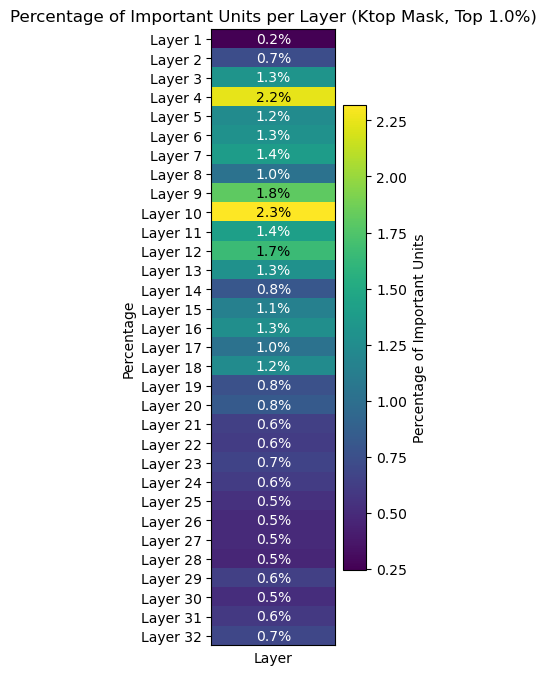

In [10]:
loc_units.plot_layer_percentages(0.01)

In [11]:
(perturbation.layer_outputs[-1].sum(dim=1) == 0).sum()

tensor(441)